In [1]:
from linkage.linkage import *
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_theme()
%matplotlib ipympl

We use gamma-linkage to discover the cluster structure of the Iris dataset

Start by importing and normalizing the dataset

In [2]:
X = preprocessing.normalize(datasets.load_iris().data)

x = MPSpace(X)
x.fit()

We run the algorithm with several choices of curve to see the evolution of the cluster structure as we vary the parameter. We see that, when the k intercept is sufficiently large, there are three high persistence vines (the two most persistent vines have very similar prominence).

In [3]:
x0 = x.connection_radius()

initial_k = 0.01 ; final_k = 0.15 ; N_PARAMETERS = 1000

gammas = [ Gamma_curve.linear_interpolator_alpha_s_indexed(k, x0) for k in np.linspace(initial_k, final_k, num=N_PARAMETERS) ]
pds = x.gamma_prominence_vineyard(gammas)

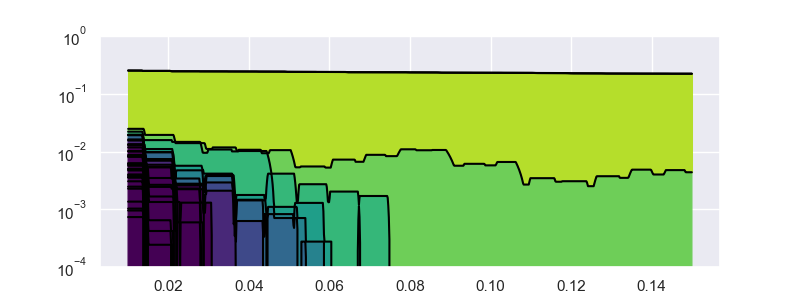

In [4]:
fig, ax = plt.subplots(figsize=(8,3))
plt.yscale("log")
plt.ylim([0.0001,1])
pv = ProminenceVineyard(np.linspace(initial_k, final_k, num=N_PARAMETERS),pds)
pv.plot_prominence_vineyard(ax)

We choose the k-intercept and the persistence threshold looking at the diagram above, and get three clusters.

We compute the confusion matrix that compares the true labels to the clustering we computed. In the confusion matrix, the first column corresponds to noise points. We see that there is only one misclassified point, but many noise points that weren't assigned any cluster.

We address this below by taking each noise point, considering its 5 closest neighbors that were assigned a cluster, and assigning the most common label among its neighbors.

In [5]:
kappa = 0.07
num_clusters = 3

gamma = Gamma_curve.linear_interpolator_alpha_s_indexed(kappa, x0)
hc = x.gamma_linkage(gamma)
c = hc.persistence_based_flattening(num_clusters = num_clusters)

In [6]:
from sklearn.neighbors import KNeighborsClassifier

def postProcessing(dataset, labels, k=5) :
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(dataset[labels!=-1], labels[labels!=-1])
    res = labels.copy()
    res[labels==-1] = neigh.predict(dataset[labels==-1,:])
    return res

confusion_matrix(postProcessing(X,c[1],5),datasets.load_iris().target)

array([[ 0,  2, 46],
       [ 0, 48,  4],
       [50,  0,  0]])